# Librerias

In [1]:
# Carga de librerías
import numpy as np
import tensorflow as tf
import PIL
import PIL.Image
import pathlib
import scipy as sp
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import os
import pathlib
from pathlib import Path   

In [2]:
import pickle
import sys
from pathlib import Path

from numpy.linalg import LinAlgError
from scipy.sparse.csgraph import laplacian
from new_spectral_metric.new_estimator_all_samples import CumulativeGradientEstimator_All_samples
from new_spectral_metric.new_visualize import make_graph
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, Dense, MaxPooling2D, Lambda
from tensorflow.keras import backend as K
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.collections import LineCollection
from matplotlib.font_manager import FontProperties
from pathlib import Path

# DATASET DESDE DIRECTORIO 

In [3]:
#Lectura de dataset

directorio_dataset = ('../../../../Datasets/CIFAR-10')
directorio_dataset = pathlib.Path(directorio_dataset)

# Lectura de la carpeta train
directorio_train = ('../../../../Datasets/CIFAR-10/train')
directorio_train = pathlib.Path(directorio_train)

# Lectura de la carpeta test
directorio_test = ('../../../../Datasets/CIFAR-10/test')
directorio_test = pathlib.Path(directorio_test)

total_dataset = len(list(directorio_dataset.glob('*/*/*.png')))  # Cuenta la cantidad de imagenes del dataset (Aqui busca en las subcarpetas del directorio del dataset)
total_train = len(list(directorio_train.glob('*/*.png')))  # Cuenta la cantidad de imagenes de train
total_test = len(list(directorio_test.glob('*/*.png')))  # Cuenta la cantidad de imagenes de test

print(f"Total imagenes dataset: {total_dataset}")
print(f"Total imagenes train: {total_train}")
print(f"Total imagenes test: {total_test}")

Total imagenes dataset: 60000
Total imagenes train: 50000
Total imagenes test: 10000


In [4]:
# Definir el batchsize del dataset completo
batch_size_total = total_dataset

In [5]:
# Dimensiones de imagen y tamaño de batch en train
img_height = 32
img_width = 32
#batch_size = 32
batch_size_train = total_train

In [6]:
# Data splitting (entrenamiento y validación)
train_images = tf.keras.preprocessing.image_dataset_from_directory(
  directorio_train,
  #validation_split=0.2,
  color_mode='rgb',
  label_mode='int',
  #subset="training",
  #seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size_train)

Found 50000 files belonging to 10 classes.


In [7]:
# Dimensiones de imagen y tamaño de batch en test
img_height = 32
img_width = 32
#batch_size = 32
batch_size_test = total_test

In [8]:
# Data splitting (entrenamiento y validación)
test_images = tf.keras.preprocessing.image_dataset_from_directory(
  directorio_test,
  #validation_split=0.2,
  color_mode='rgb',
  label_mode='int',
  #subset="training",
  #seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size_test)

Found 10000 files belonging to 10 classes.


In [9]:
# Contar el total de imágenes por clase en train y test  
class_counts_total = {p.name: len(list(p.glob('*.png'))) for p in directorio_dataset.glob('*/*')}  
class_counts_train = {p.name: len(list(p.glob('*.png'))) for p in directorio_train.glob('*')}  
class_counts_test = {p.name: len(list(p.glob('*.png'))) for p in directorio_test.glob('*')}  

# Encontrar el valor más bajo de imágenes por clase en train  
menor_train = min(class_counts_train.values()) if class_counts_train else None  # Se almacena el valor de la clase que menos muestras tiene

# Encontrar el valor más alto de imágenes por clase en train  
mayor_train = max(class_counts_train.values()) if class_counts_train else None  # Se almacena el valor de la clase que mas muestras tiene


# Encontrar el valor más bajo de imágenes por clase en test  
menor_test = min(class_counts_test.values()) if class_counts_test else None  # Se almacena el valor de la clase que menos muestras tiene

# Encontrar el valor más alto de imágenes por clase en test  
mayor_test = max(class_counts_test.values()) if class_counts_test else None  # Se almacena el valor de la clase que mas muestras tiene


# Mostrar el total de imágenes por clase en train  
print("\nTotal images per class in train:")  
for class_name, count in class_counts_train.items():  
    print(f"Class: {class_name}, Number of images: {count}")  
print(f"Total images train: {sum(class_counts_train.values())}")  

# Mostrar el valor más bajo en train  
print(f"Fewer number of images in train: {menor_train}")  

# Mostrar el valor más alto en train  
print(f"Higher number of images in train: {mayor_train}")  

# Mostrar el total de imágenes por clase en test  
print("\nTotal images per class in test:")  
for class_name, count in class_counts_test.items():  
    print(f"Class: {class_name}, Number of images: {count}")  
print(f"Total images test: {sum(class_counts_test.values())}")  

# Mostrar el valor más bajo en test  
print(f"Fewer images in test: {menor_test}")

# Mostrar el valor más alto en test  
print(f"Higher number of images in test: {mayor_test}")


Total images per class in train:
Class: airplane_train, Number of images: 5000
Class: automobile_train, Number of images: 5000
Class: bird_train, Number of images: 5000
Class: cat_train, Number of images: 5000
Class: deer_train, Number of images: 5000
Class: dog_train, Number of images: 5000
Class: frog_train, Number of images: 5000
Class: horse_train, Number of images: 5000
Class: ship_train, Number of images: 5000
Class: truck_train, Number of images: 5000
Total images train: 50000
Fewer number of images in train: 5000
Higher number of images in train: 5000

Total images per class in test:
Class: airplane_test, Number of images: 1000
Class: automobile_test, Number of images: 1000
Class: bird_test, Number of images: 1000
Class: cat_test, Number of images: 1000
Class: deer_test, Number of images: 1000
Class: dog_test, Number of images: 1000
Class: frog_test, Number of images: 1000
Class: horse_test, Number of images: 1000
Class: ship_test, Number of images: 1000
Class: truck_test, Num

In [10]:
# Nombres de las clases
class_names_train = list(class_counts_train.keys())
class_names_test = list(class_counts_test.keys())
#class_names_total = sorted(list(set(class_names_train + class_names_test)))
class_names_total = list(class_counts_total.keys())

# Mostrar el número de clases y los nombres
print(f"\nNúmero de clases en train: {len(class_names_train)}")
print(f"Nombres de las clases en train: {class_names_train}")

print(f"\nNúmero de clases en test: {len(class_names_test)}")
print(f"Nombres de las clases en test: {class_names_test}")

print(f"\nNúmero total de clases en el dataset: {len(class_names_total)}")   # Este valor cambia si el nombre de las clases es diferente
print(f"Nombres de todas las clases en el dataset: {class_names_total}")     # Este valor tambien cambia si el nombre de las clases es diferente


Número de clases en train: 10
Nombres de las clases en train: ['airplane_train', 'automobile_train', 'bird_train', 'cat_train', 'deer_train', 'dog_train', 'frog_train', 'horse_train', 'ship_train', 'truck_train']

Número de clases en test: 10
Nombres de las clases en test: ['airplane_test', 'automobile_test', 'bird_test', 'cat_test', 'deer_test', 'dog_test', 'frog_test', 'horse_test', 'ship_test', 'truck_test']

Número total de clases en el dataset: 20
Nombres de todas las clases en el dataset: ['airplane_test', 'automobile_test', 'bird_test', 'cat_test', 'deer_test', 'dog_test', 'frog_test', 'horse_test', 'ship_test', 'truck_test', 'airplane_train', 'automobile_train', 'bird_train', 'cat_train', 'deer_train', 'dog_train', 'frog_train', 'horse_train', 'ship_train', 'truck_train']


In [11]:
for images, labels0 in train_images.take(1):  # only take first element of dataset
    numpy_all_images = images.numpy()  # convertir el tensor de imágenes en un arreglo de numpy y ahora contiene las imágenes del conjunto de datos en formato de numpy.
    numpy_all_labels = labels0.numpy()  # convierte el tensor de etiquetas en un arreglo de numpy y ahora contiene las etiquetas del conjunto de datos en formato de numpy

numpy_all_images /= 255.0  # Scale the features to the [0, 1] range
print(numpy_all_images.shape)

# CIFAR-10 
fully_dataset_train = numpy_all_images.reshape((numpy_all_images.shape[0], numpy_all_images.shape[1]*numpy_all_images.shape[2]*numpy_all_images.shape[3])) # es un arreglo bidimensional donde cada fila representa una imagen y cada columna representa un píxel de la imagen
fully_labels_train = numpy_all_labels.reshape(numpy_all_labels.shape[0],)

(50000, 32, 32, 3)


# Dataset complexity using CSG

c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  ret

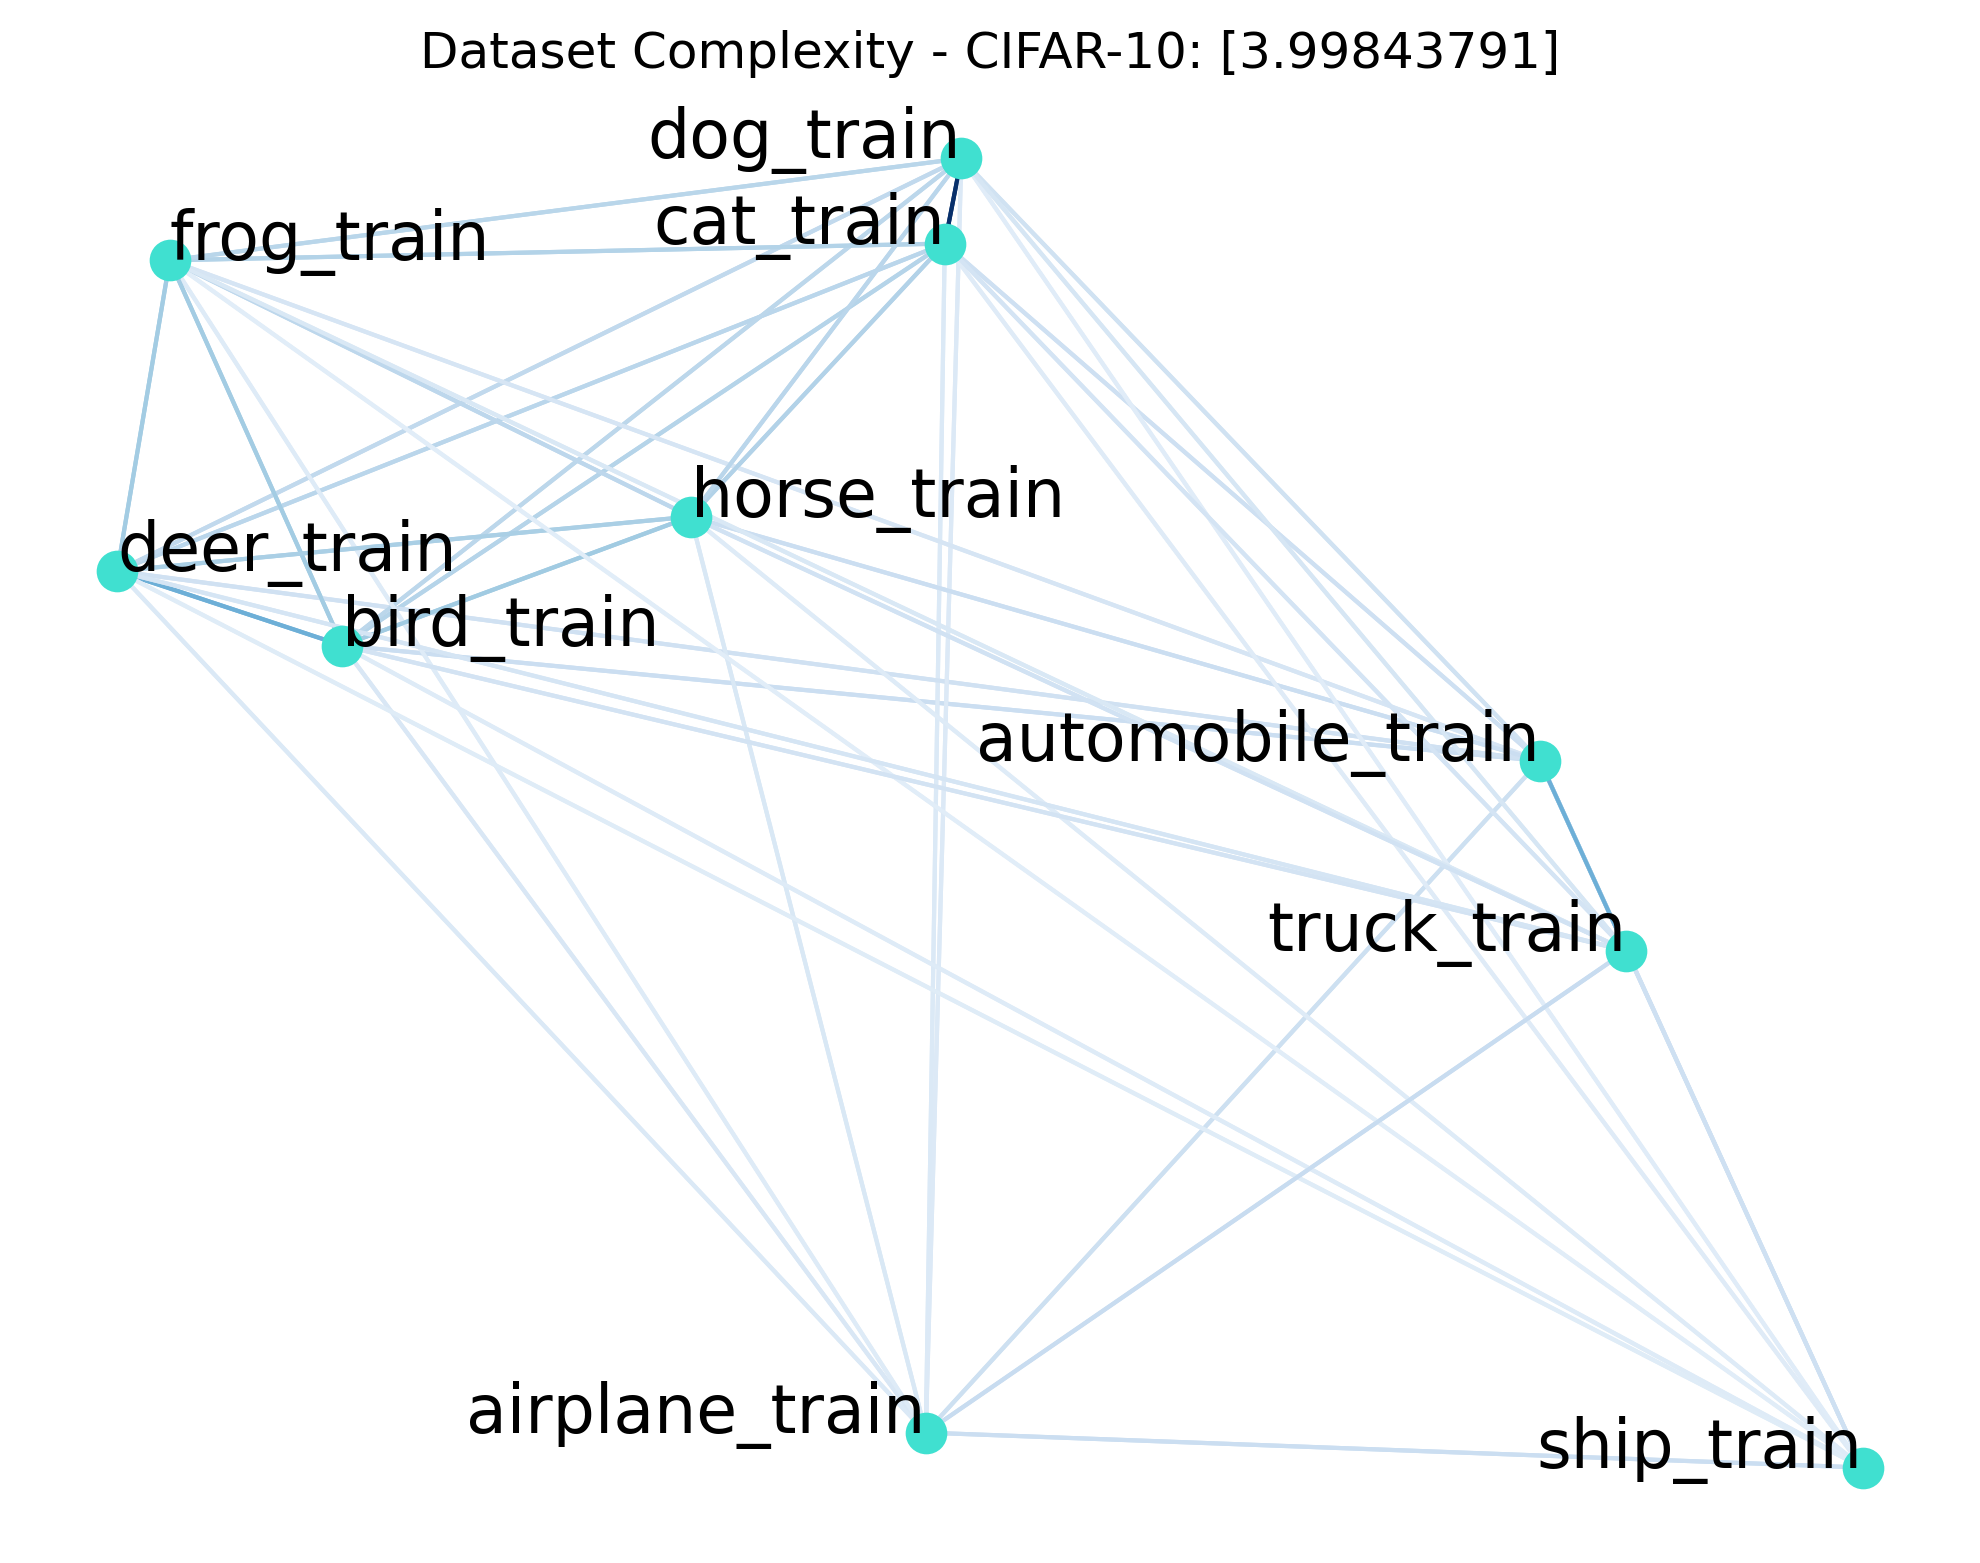

In [12]:

estimator = CumulativeGradientEstimator_All_samples(M_sample=mayor_train, k_nearest=10)  # Utiliza el numero menor de muestras encontrado en cada clase dependiendo si es train o test
estimator.fit(data=fully_dataset_train, target=fully_labels_train)
csg = estimator.csg  # The actual complexity values.
estimator.evals, estimator.evecs  # The eigenvalues and vectors.

make_graph(estimator.difference, title="Dataset Complexity - CIFAR-10: "+str(csg), classes=class_names_train)

# Calcular la similitud entre clases

In [13]:

from scipy.stats import entropy
import pandas as pd

# Calcular la entropía por clase  
entropy_per_class = entropy(estimator.W / estimator.W.sum(-1)[:, None], axis=-1)  

# Encontrar la clase menos confusa (menor entropía)  
least_confused_class_index = np.argmin(entropy_per_class)  
least_confused_class_name = class_names_train[least_confused_class_index]  

print("Class that is the least confused (lowest entropy):", least_confused_class_name)

Class that is the least confused (lowest entropy): ship_train


In [14]:

# Obtener los índices de los pares menos similares  
pairs = list(zip(*np.unravel_index(np.argsort(estimator.W, axis=None), estimator.W.shape)))  

# Filtrar pares donde i != j para evitar pares de la misma clase  
pairs = [(i, j) for i, j in pairs if i != j]  

print("Least similar pairs")  
lst = []  
seen_pairs = set()  

# Iterar sobre los primeros 10 pares menos similares  
for i, j in pairs:  
    # Verificar si el par o su inverso ya ha sido visto  
    if (i, j) not in seen_pairs and (j, i) not in seen_pairs:  
        lst.append({"Intent pair": f"{class_names_train[i]} <> {class_names_train[j]}", "Similarity": estimator.W[i, j]})  
        seen_pairs.add((i, j))  
        seen_pairs.add((j, i))  
    
    # Detenerse después de encontrar 10 pares únicos  
    if len(lst) == 10:  
        break  

# Mostrar los resultados en un DataFrame  
print(pd.DataFrame(lst))

Least similar pairs
                    Intent pair  Similarity
0      ship_train <> frog_train    0.318416
1       dog_train <> ship_train    0.358824
2      deer_train <> ship_train    0.379392
3       cat_train <> ship_train    0.384983
4     horse_train <> ship_train    0.404236
5  airplane_train <> frog_train    0.410991
6      bird_train <> ship_train    0.414651
7   airplane_train <> dog_train    0.451513
8  airplane_train <> deer_train    0.472082
9   cat_train <> airplane_train    0.477673


# Obtener los nombres de las imagenes en train o test (dependiendo de lo que se quiera probar)

In [15]:
# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_train.glob('*/*.png')]

# Crear un mapeo de índices a rutas completas de archivo  
filenames_dict = {i: str(f) for i, f in enumerate(directorio_train.glob('*/*.png'))} 


# Calcular la similitud entre muestras

Muestras menos similares entre todas las imágenes del dataset 

Forma de la matriz M: (50000, 50000)
bird_of_passage_s_000671.png vs western_toad_s_000620.png, Similitud: 0.0257
stealth_bomber_s_000713.png vs western_toad_s_000620.png, Similitud: 0.0281
western_toad_s_000620.png vs containership_s_000963.png, Similitud: 0.0294
stealth_bomber_s_000713.png vs semi_s_001511.png, Similitud: 0.0304
western_toad_s_000620.png vs felis_catus_s_001609.png, Similitud: 0.0325
western_toad_s_000620.png vs mouser_s_001307.png, Similitud: 0.0333
jetliner_s_000563.png vs western_toad_s_000620.png, Similitud: 0.0347
semi_s_001511.png vs cat_s_002785.png, Similitud: 0.0349
domestic_cat_s_001530.png vs airliner_s_000356.png, Similitud: 0.0352
honey_eater_s_000785.png vs western_toad_s_000620.png, Similitud: 0.0354
cargo_ship_s_000979.png vs western_toad_s_000620.png, Similitud: 0.0357
rana_temporaria_s_001805.png vs western_toad_s_000620.png, Similitud: 0.0361
stealth_bomber_s_000713.png vs toad_s_00098

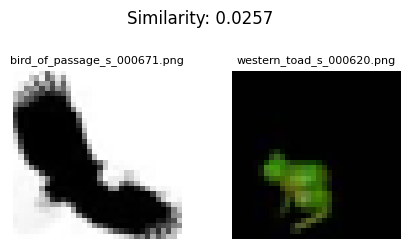

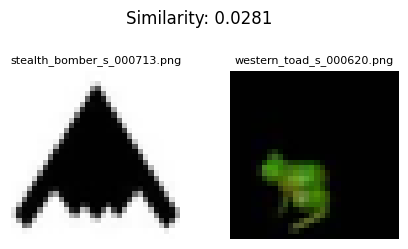

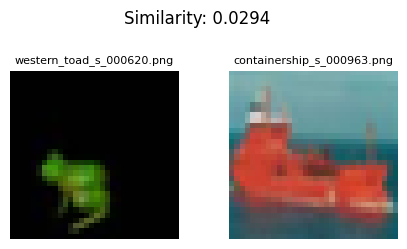

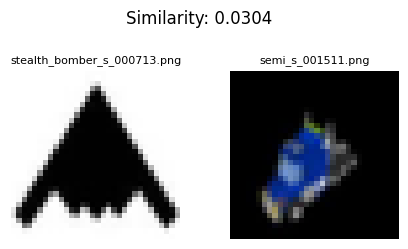

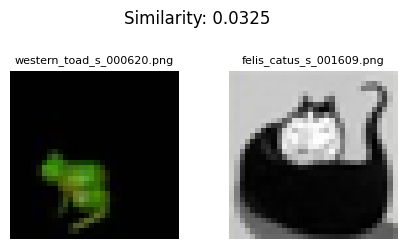

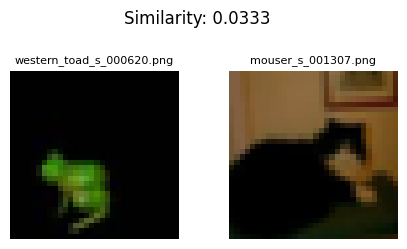

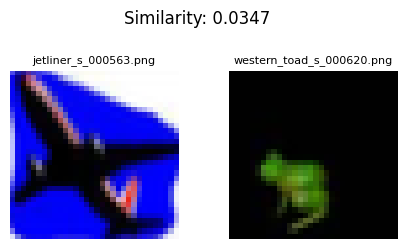

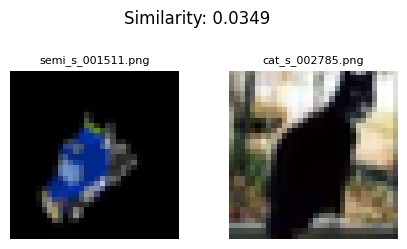

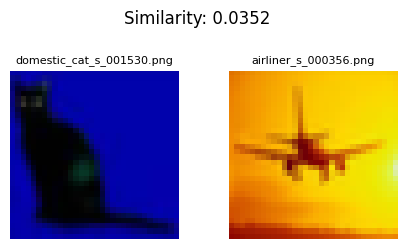

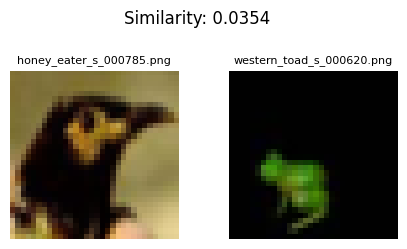

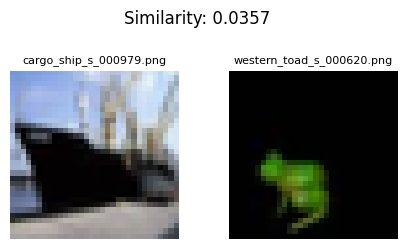

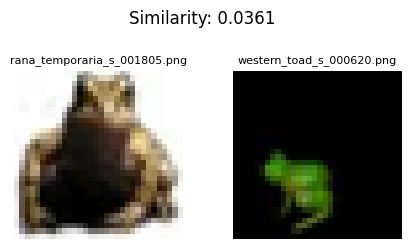

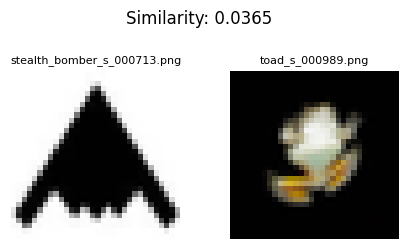

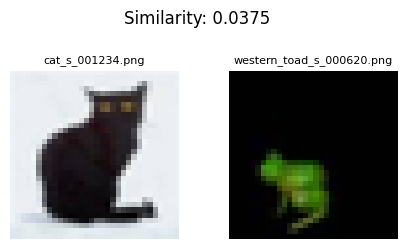

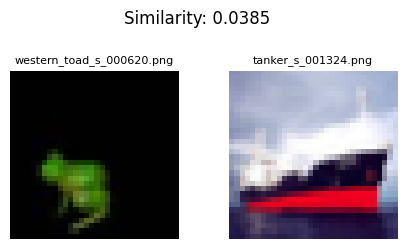

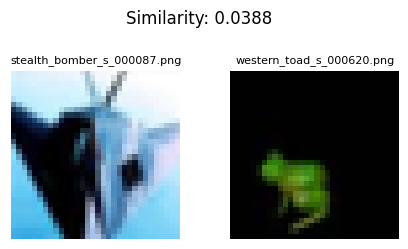

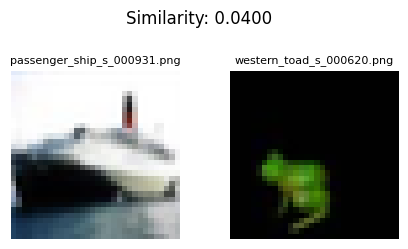

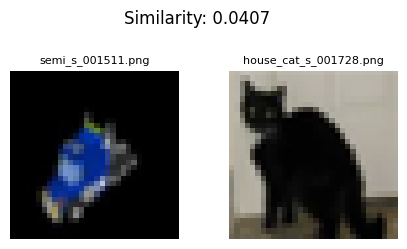

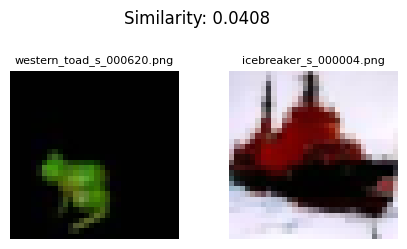

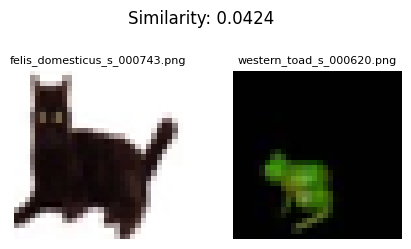

In [16]:
# Función para encontrar y mostrar las imágenes menos similares usando la matriz M  
def show_least_similar_using_M(estimator, filenames_dict):  
    images_to_show = []  # Lista para almacenar las imágenes y sus detalles  

    # Obtener la matriz de similitud global (M)  
    M = estimator.M  

    # Imprimir la forma de la matriz de similitud  
    print(f"Forma de la matriz M: {M.shape}")  

    # Ordenar los índices según las similitudes (de menor a mayor)  
    least_similar_indices = np.argsort(M, axis=None)  

    shown_pairs = set()  # Para rastrear los pares de índices ya mostrados  
    count = 0  
    show_samples = 20  # Número de muestras para visualizar la similitud  

    # Diccionario para contar la participación de cada imagen  
    participation_count = {}  

    for idx in least_similar_indices:  
        if count >= show_samples:  
            break  

        # Convertir el índice plano a índice 2D  
        idx_2d = np.unravel_index(idx, M.shape)  

        # Saltar las comparaciones de una muestra consigo misma  
        if idx_2d[0] == idx_2d[1]:  
            continue  

        # Crear un par ordenado de índices para prevenir duplicados  
        index_pair = tuple(sorted((idx_2d[0], idx_2d[1])))  

        # Verificamos si el par ya fue mostrado  
        if index_pair in shown_pairs:  
            continue  

        shown_pairs.add(index_pair)  

        # Actualizar el conteo de participación  
        participation_count[idx_2d[0]] = participation_count.get(idx_2d[0], 0) + 1  
        participation_count[idx_2d[1]] = participation_count.get(idx_2d[1], 0) + 1  

        # Verificar que los índices estén dentro de los límites del dataset  
        if idx_2d[0] < len(filenames_dict) and idx_2d[1] < len(filenames_dict):  
            source_filename = Path(filenames_dict[int(idx_2d[0])])  
            target_filename = Path(filenames_dict[int(idx_2d[1])])  

            value = M[idx_2d]  

            # Formatear y mostrar la salida  
            print(f"{source_filename.name} vs {target_filename.name}, Similitud: {value:.4f}")  

            # Agrega los detalles a la lista para visualización  
            images_to_show.append((source_filename, target_filename, value))  

            count += 1  

    # Encontrar las muestras más atípicas  
    most_atypical = sorted(participation_count.items(), key=lambda x: -x[1])  

    # Mostrar las 10 más atípicas  
    print("\nMuestras más atípicas del dataset:")  
    for rank, (img_idx, freq) in enumerate(most_atypical[:10], 1):  
        img_name = Path(filenames_dict[int(img_idx)]).name  
        print(f"\t#{rank}: {img_name} con {freq} apariciones")  
    print("\n")  

    # Luego, realiza la visualización de las imágenes  
    for source_filename, target_filename, value in images_to_show:  
        img_source = plt.imread(source_filename)  
        img_target = plt.imread(target_filename)  

        fig, axs = plt.subplots(1, 2, figsize=(5, 3))  
        axs[0].imshow(img_source)  
        axs[0].set_title(f"{source_filename.name}", fontsize=8)  
        axs[0].axis('off')  # Elimina los ejes para centrar la atención en la imagen  

        axs[1].imshow(img_target)  
        axs[1].set_title(f"{target_filename.name}", fontsize=8)  
        axs[1].axis('off')  
        plt.suptitle(f"Similarity: {value:.4f}")  
        plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Ajusta el espacio entre subtramas  
        plt.show()  


print("Muestras menos similares entre todas las imágenes del dataset \n")  
show_least_similar_using_M(estimator, filenames_dict)